### Modules and parameters

In [3]:
using LinearAlgebra
using DifferentialEquations
using FFTW
using Random
using Distributions
using DSP
using Plots
using StatsBase
using NPZ

include("../src/SpectralDensity.jl");
include("../src/Noise.jl");
include("../src/StochasticField.jl");

In [4]:
Δt = 0.15
N = 100_000
Random.seed!(123) # the exclamation mark here is warning us that we are changing a global property, in this case the random seed

prm = LorentzianSD(10., 5., 5.);
nss = ClassicalNoise(1.);

fpsd = psd(prm, nss);
sptr = spectrum(nss);

### Misc

In [6]:
2*prm.α*prm.Γ*1/prm.ω0^4 # this is noise(ω)*Im{K(ω)} evaluated at ω=0

0.16

In [7]:
mean(b_field(N, Δt, prm, nss)) # mean of the b_field equals 0

0.009114571326819398

### Comparing periodogram of b_field generated and psd

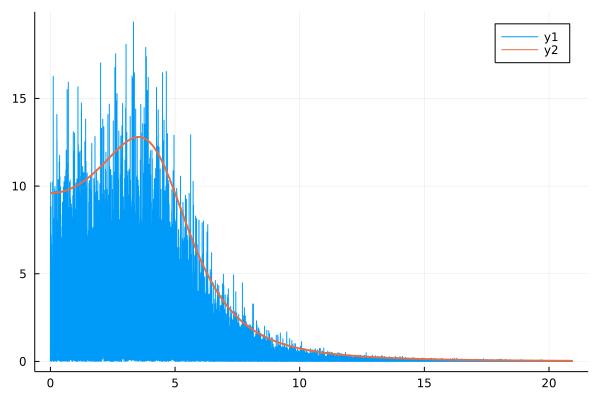

In [5]:
psd_test = periodogram(b_field(N, Δt, prm, nss), nfft=N, fs=1/Δt)

plot(2π*freq(psd_test), power(psd_test))
plot!(2π*rfftfreq(N, 1/Δt), fpsd.(ang_freq_test)*60, lw=2)

### Comparing autocorrelation of b_field generated and psd

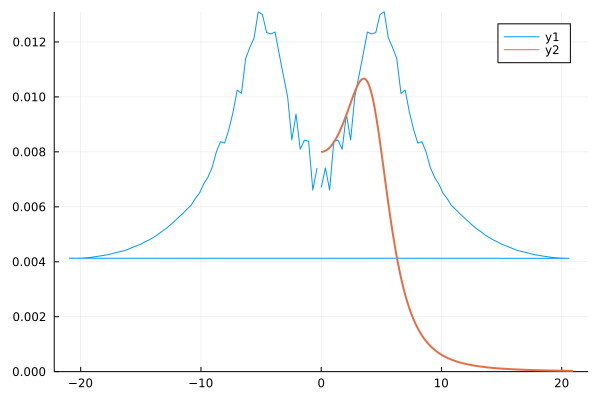

In [15]:
ang_freq_test = 2π*rfftfreq(N, 1/Δt);

plot(2π*fftfreq(120, 1/Δt), abs.(ifft(autocor(b_field(N, Δt, prm, nss), 1:120))), ylims=(0, Inf))
plot!(ang_freq_test, fpsd.(ang_freq_test)/20, lw=2)

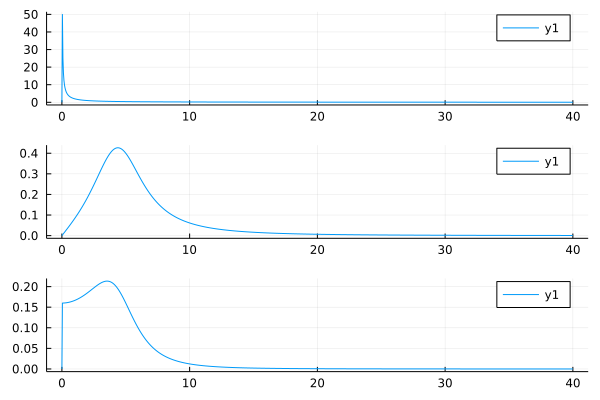

In [16]:
freq_range = LinRange(0, 40, 1000)
a_test = spectrum(nss).(freq_range)
b_test = imag.(damping_kernel_frequency(prm).(freq_range))
p1 = plot(freq_range, a_test);
p2 = plot(freq_range, b_test);
p3 = plot(freq_range, a_test.*b_test)
plot(p1, p2, p3, layout=(3, 1))

### Python/Julia noise comparison

In [19]:
distrosample = npzread("../../ASHCodeParallel/noise.npz")["arr_0"];
N = length(distrosample)

321592

In [20]:
# NB: this function is NOT equal to b_field!! Here, there is a factor 2 in psdfft to
# compensate for the spin 1/2 in python. In b_field however, there is no factor 2 and
# there is a factor 2π to port the frequency fft to a angular frequency fft.

function b_field_test(N, Δt, J::SpectralDensity, noise::Noise)
    distrosamplefft = rfft(distrosample)
    psdfft = 2*psd(J, noise).(2π*rfftfreq(N, 1/Δt)) # NB: rfftfreq(N, 1/Δt) takes the frequency step in input!
    bfft = sqrt.(psdfft).*distrosamplefft
    return irfft(bfft, N)
end

b_field_test (generic function with 1 method)

In [22]:
var_b_field_test = b_field_test(N, Δt, prm, nss)
plot(var_b_field_test)

In [211]:
npzwrite("../../ASHCodeParallel/bfield.npz", -var_b_field_test)